# Load Package and Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib.path import Path
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import norm, linregress
from scipy.optimize import minimize

In [2]:
n = 1000 # jumlah titik acak
m = 10  # jumlah pengulangan simulasi

batas = pd.read_csv('../Data/Lat Long M8.csv')

R = 6371 # Radius of the Earth in kilometers

data = pd.read_csv('../Data/M8 Declustering.csv')
u = 5.5
e = 0.00001

# Location

In [3]:
boundaries = batas[['longitude', 'latitude']].values
polygon_path = Path(boundaries)

def is_inside(point, path):
    return path.contains_point(point)

def monte_carlo_polygon(boundaries, num_points, path):
    min_x, min_y = np.min(boundaries, axis=0)
    max_x, max_y = np.max(boundaries, axis=0)
    points = []
    while len(points) < num_points:
        x = np.random.uniform(min_x, max_x)
        y = np.random.uniform(min_y, max_y)
        if is_inside((x, y), path):
            points.append((x, y))
    return np.array(points)

simulasi = monte_carlo_polygon(boundaries, n, polygon_path)

# Simpan ke DataFrame
simulasi = pd.DataFrame(simulasi, columns=['Longitude', 'Latitude'])
print(simulasi.head())

# Plot hasil simulasi di peta dengan scatter_mapbox
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik Uniform dalam Poligon Batas",
    mapbox_style="open-street-map"
)

# Tambahkan outline poligon batas area
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)

fig.show()

    Longitude  Latitude
0  107.530473 -8.092725
1  108.124431 -8.701225
2  107.948411 -7.753357
3  107.593879 -9.343327
4  108.150944 -8.880874


# Kedalaman

Fungsi-fungsi yang dipakai

In [4]:
from math import radians, cos, sin, asin, sqrt, atan, tan, degrees

In [5]:
def longlat_to_xyz(lon, lat, R=6371):
    lon, lat = radians(lon), radians(lat)
    x = R * cos(lat) * cos(lon)
    y = R * cos(lat) * sin(lon)
    z = R * sin(lat)
    return x, y, z

def project_point_to_line(p, a, b):
    a, b, p = np.array(a), np.array(b), np.array(p)
    d = b - a  # Vektor arah garis ab
    ap = p - a  # Vektor dari a ke p
    proj_ap_onto_d = (np.dot(ap, d) / np.dot(d, d)) * d  # Proyeksi ap ke d
    q = a + proj_ap_onto_d  # Titik hasil proyeksi di garis ab
    return q

def xyz_to_longlat(x, y, z, R=6371):
    lat = np.degrees(np.arcsin(z / R))
    lon = np.degrees(np.arctan2(y, x))
    return lon, lat

def haversine(lat1, lon1, lat2, lon2):
    dlat = radians(lat2)-radians(lat1)
    dlon = radians(lon2)-radians(lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c  # Jarak dalam km

Derajat trigonometri

Jarak antara (106.45, -9.08) dan (107.15, -7.30) adalah: 212.39 km
Jarak antara (109.94, -8.55) dan (109.68, -10.08) adalah: 172.50 km
Rata-rata jarak = 192.45 km
Besar derajatnya adalah 17.32 derajat


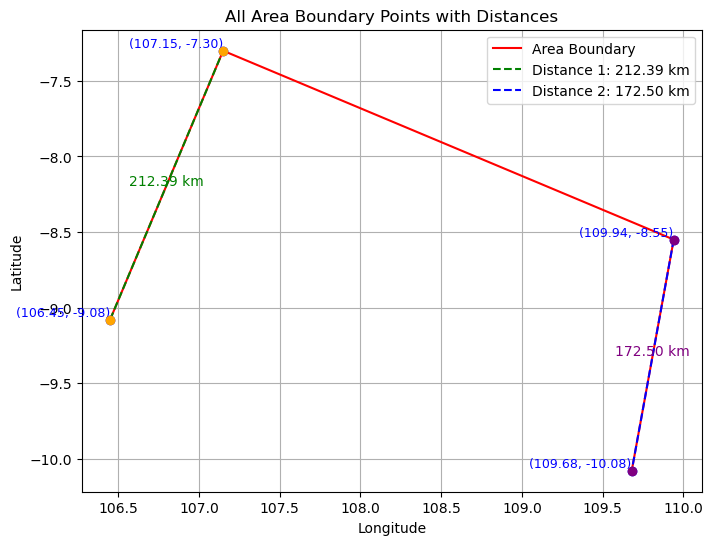

In [6]:
# Pastikan data cukup
if len(batas) < 4:
    raise ValueError("Data batas kurang dari 4 baris, tidak bisa menghitung dua pasang jarak.")

# Ambil empat titik pertama dari data batas
lon1, lat1 = batas.iloc[0][['longitude', 'latitude']]
lon2, lat2 = batas.iloc[1][['longitude', 'latitude']]
lon3, lat3 = batas.iloc[2][['longitude', 'latitude']]
lon4, lat4 = batas.iloc[3][['longitude', 'latitude']]

# Hitung jarak antar pasangan titik
jarak1 = haversine(lat1, lon1, lat2, lon2)
jarak2 = haversine(lat3, lon3, lat4, lon4)
rata_jarak = (jarak1 + jarak2) / 2

print(f"Jarak antara ({lon1:.2f}, {lat1:.2f}) dan ({lon2:.2f}, {lat2:.2f}) adalah: {jarak1:.2f} km")
print(f"Jarak antara ({lon3:.2f}, {lat3:.2f}) dan ({lon4:.2f}, {lat4:.2f}) adalah: {jarak2:.2f} km")
print(f"Rata-rata jarak = {rata_jarak:.2f} km")

# Hitung theta (misal ingin membandingkan dengan lebar 60 km)
theta = atan(60 / rata_jarak)
print(f"Besar derajatnya adalah {degrees(theta):.2f} derajat")

# Plot semua titik batas dan beri nama (long, lat)
plt.figure(figsize=(8, 6))
plt.plot(batas['longitude'], batas['latitude'], 'r-', label='Area Boundary')
plt.scatter(batas['longitude'], batas['latitude'], color='blue', zorder=5)

# Tulis nama semua titik (long, lat)
for i, row in batas.iterrows():
    plt.text(row['longitude'], row['latitude'], f"({row['longitude']:.2f}, {row['latitude']:.2f})", 
             fontsize=9, ha='right', va='bottom', color='blue')

# Tandai dan beri label jarak pada pasangan titik
plt.scatter([lon1, lon2], [lat1, lat2], color='orange', zorder=6)
plt.plot([lon1, lon2], [lat1, lat2], 'g--', label=f'Distance 1: {jarak1:.2f} km')
plt.text((lon1+lon2)/2, (lat1+lat2)/2, f"{jarak1:.2f} km", color='green', fontsize=10, ha='center')

plt.scatter([lon3, lon4], [lat3, lat4], color='purple', zorder=6)
plt.plot([lon3, lon4], [lat3, lat4], 'b--', label=f'Distance 2: {jarak2:.2f} km')
plt.text((lon3+lon4)/2, (lat3+lat4)/2, f"{jarak2:.2f} km", color='purple', fontsize=10, ha='center')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('All Area Boundary Points with Distances')
plt.legend()
plt.grid(True)
plt.show()

Menghitung kedalaman

In [7]:
# Ambil titik ke-1 dan ke-4 dari DataFrame batas
boundaries = batas.iloc[[0, 3]][['longitude', 'latitude']].values
print(boundaries)

# Konversi dan proyeksi langsung
simulasi[['x', 'y', 'z']] = simulasi.apply(lambda row: pd.Series(longlat_to_xyz(row['Longitude'], row['Latitude'])), axis=1)
bound = pd.DataFrame(boundaries, columns=['longitude', 'latitude'])
bound[['x', 'y', 'z']] = bound.apply(lambda row: pd.Series(longlat_to_xyz(row['longitude'], row['latitude'])), axis=1)

# Proyeksi ke satu garis saja (dari titik ke-2 ke titik ke-3)
a, b = bound.iloc[0][['x', 'y', 'z']].values, bound.iloc[1][['x', 'y', 'z']].values
q_points = simulasi.apply(lambda row: project_point_to_line(row[['x', 'y', 'z']].values, a, b), axis=1)
q_longlats = pd.DataFrame([xyz_to_longlat(*q) for q in q_points], columns=['q_lon', 'q_lat'])

simulasi[['q_lon', 'q_lat']] = q_longlats

# Hitung jarak dan kedalaman
simulasi['Jarak_epi'] = simulasi.apply(lambda row: haversine(row['Latitude'], row['Longitude'], row['q_lat'], row['q_lon']), axis=1)
simulasi['Jarak'] = 2 * R * np.sin(simulasi['Jarak_epi'] / (2 * R))
simulasi['Kedalaman (km)'] = simulasi['Jarak'] * np.tan(theta)

# Hapus kolom yang tidak diperlukan
columns_to_drop = ['x', 'y', 'z', 'q_lon', 'q_lat']
simulasi.drop(columns=columns_to_drop, inplace=True)

print(simulasi.head())

# Scatter mapbox dengan warna berdasarkan kedalaman
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    color="Kedalaman (km)",
    color_continuous_scale="Viridis",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik & Kedalaman (warna = kedalaman)",
    mapbox_style="open-street-map"
)

# Tambahkan outline poligon batas area
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)

# Atur posisi legend agar tidak tabrakan
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()

[[106.45  -9.08]
 [109.68 -10.08]]
    Longitude  Latitude   Jarak_epi       Jarak  Kedalaman (km)
0  107.530473 -8.092725  140.290460  140.287625       43.737932
1  108.124431 -8.701225   95.232019   95.231133       29.690522
2  107.948411 -7.753357  190.042668  190.035623       59.248028
3  107.593879 -9.343327    9.675766    9.675765        3.016645
4  108.150944 -8.880874   77.039650   77.039181       24.018757


# Magnitudo

## Burr-GPD

In [8]:
def log_likelihood_burr_gpd(params, data, u):
    theta, gamma, alpha, xi, sigma_gpd = params
    if theta <= 0 or gamma <= 0 or alpha <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Burr part
    ll_burr = np.sum(
        np.log(alpha) + np.log(gamma) + gamma * np.log(below_u / theta)
        - np.log(below_u)
        - (alpha + 1) * np.log(1 + (below_u / theta) ** gamma)
    )
    
    # CDF Burr di u
    F_u = 1 - 1 / (1 + (u / theta) ** gamma) ** alpha
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_burr + ll_gpd)  # negative for minimization

def estimate_burr_gpd(data, u):
    theta0 = np.median(data[data < u])
    gamma0 = 1.5
    alpha0 = 2.0
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (1e-6, None),      # theta (skala Burr)
        (1e-6, None),      # gamma (bentuk 1 Burr)
        (1e-6, None),      # alpha (bentuk 2 Burr)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_burr_gpd,
        x0=[theta0, gamma0, alpha0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    theta, gamma, alpha, xi, sigma_gpd = result.x
    print("Estimasi Parameter Burr-GPD")
    print("Parameter Burr:")
    print(f"\\theta (skala) = {theta:.4f}")
    print(f"\\gamma (bentuk 1) = {gamma:.4f}")
    print(f"\\alpha (bentuk 2) = {alpha:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return theta, gamma, alpha, xi, sigma_gpd

def burr_comp_cdf(x, theta, gamma, alpha, xi, sigma_gpd, u):
    # CDF komposit Burr-GPD
    F = 1 - 1 / (1 + (np.minimum(x, u) / theta) ** gamma) ** alpha
    if np.isscalar(x):
        if x < u:
            return F
        else:
            F_u = 1 - 1 / (1 + (u / theta) ** gamma) ** alpha
            if xi != 0:
                cdf_gpd = 1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        F_u = 1 - 1 / (1 + (u / theta) ** gamma) ** alpha
        cdf = np.where(
            x < u,
            F,
            np.where(
                xi != 0,
                1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

In [9]:
theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd = estimate_burr_gpd(data['mag'].values, u)

Estimasi Parameter Burr-GPD
Parameter Burr:
\theta (skala) = 4.4994
\gamma (bentuk 1) = 23.8901
\alpha (bentuk 2) = 0.5066
Parameter GPD:
u (threshold) = 5.5000
\xi (bentuk) = -0.1028
\sigma (skala) = 0.4300


C:\Users\user\AppData\Local\Temp\ipykernel_15024\666777911.py:23: RuntimeWarning:

invalid value encountered in log



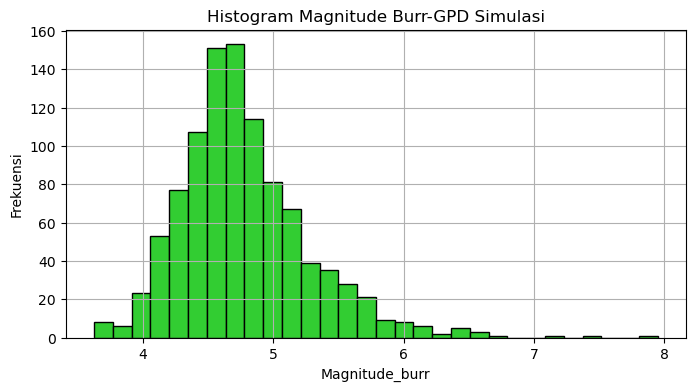

In [10]:
# 1. Generate uniform random numbers
u_rand = np.random.uniform(0, 1, n)

# 2. Inverse transform sampling untuk Burr-GPD
def burr_gpd_ppf(p, theta, gamma, alpha, xi, sigma_gpd, u):
    # Hitung proporsi Burr
    F_u = 1 - 1 / (1 + (u / theta) ** gamma) ** alpha
    x = np.zeros_like(p)
    # Bagian Burr
    mask_burr = p < F_u
    x[mask_burr] = theta * ((1 - p[mask_burr]) ** (-1 / alpha) - 1) ** (1 / gamma)
    # Bagian GPD
    mask_gpd = ~mask_burr
    p_gpd = (p[mask_gpd] - F_u) / (1 - F_u)
    if xi != 0:
        x[mask_gpd] = u + sigma_gpd / xi * (1 - (1 - p_gpd) ** xi)
    else:
        x[mask_gpd] = u - sigma_gpd * np.log(1 - p_gpd)
    return x

# 3. Generate magnitude
simulasi['Magnitude_burr'] = burr_gpd_ppf(
    u_rand, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u
)

# 4. Hitung Event Rate
cdf_plus = burr_comp_cdf(simulasi['Magnitude_burr'] + e, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u)
cdf_minus = burr_comp_cdf(simulasi['Magnitude_burr'] - e, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u)
simulasi['Event Rate_burr'] = (cdf_plus - cdf_minus) / 124

# --- Visualisasi ---
# Scatter mapbox warna = Magnitude_burr
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    color="Magnitude_burr",
    color_continuous_scale="Turbo",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik & Magnitude Burr-GPD (warna = magnitude)",
    mapbox_style="open-street-map"
)
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)"
    )
)
fig.show()

# Histogram magnitude
plt.figure(figsize=(8,4))
plt.hist(simulasi['Magnitude_burr'], bins=30, color='limegreen', edgecolor='k')
plt.xlabel('Magnitude_burr')
plt.ylabel('Frekuensi')
plt.title('Histogram Magnitude Burr-GPD Simulasi')
plt.grid(True)
plt.show()

In [11]:
simulasi

,Longitude,Latitude,Jarak_epi,Jarak,Kedalaman (km),Magnitude_burr,Event Rate_burr
0,107.530473,-8.092725,140.290460,140.287625,43.737932,4.268478,8.913879e-08
1,108.124431,-8.701225,95.232019,95.231133,29.690522,4.808789,1.371884e-07
2,107.948411,-7.753357,190.042668,190.035623,59.248028,3.963191,2.213808e-08
3,107.593879,-9.343327,9.675766,9.675765,3.016645,4.525165,1.564735e-07
4,108.150944,-8.880874,77.039650,77.039181,24.018757,4.274694,9.108195e-08
...,...,...,...,...,...,...,...
995,109.115350,-9.624019,29.846614,29.846587,9.305368,4.482377,1.496608e-07
996,108.971932,-8.811967,111.304713,111.303298,34.701393,5.500592,3.281853e-08
997,109.264175,-9.636333,33.423919,33.423881,10.420673,5.152044,6.938819e-08
998,108.648319,-8.899073,91.438931,91.438146,28.507970,3.980778,2.431111e-08


## Loglogistic-GPD

In [12]:
def log_likelihood_loglogistic_gpd(params, data, u):
    theta, gamma, xi, sigma_gpd = params
    if theta <= 0 or gamma <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Loglogistic part
    ll_loglog = np.sum(
        np.log(gamma) + gamma * np.log(below_u / theta) - np.log(below_u) - 2 * np.log(1 + (below_u / theta) ** gamma)
    )
    
    # CDF loglogistic di u
    F_u = (u / theta) ** gamma / (1 + (u / theta) ** gamma)
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_loglog + ll_gpd)  # negative for minimization

def estimate_loglogistic_gpd(data, u):
    theta0 = np.median(data[data < u])
    gamma0 = 1.5
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (1e-6, None),      # theta (skala Loglogistic)
        (1e-6, None),      # gamma (bentuk Loglogistic)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_loglogistic_gpd,
        x0=[theta0, gamma0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    theta, gamma, xi, sigma_gpd = result.x
    print("Estimasi Parameter Loglogistic-GPD")
    print("Parameter Loglogistic:")
    print(f"\\theta (skala) = {theta:.4f}")
    print(f"\\gamma (bentuk) = {gamma:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return theta, gamma, xi, sigma_gpd

def loglogistic_comp_cdf(x, theta, gamma, xi, sigma_gpd, u):
    # CDF komposit Loglogistic-GPD
    F = (np.minimum(x, u) / theta) ** gamma / (1 + (np.minimum(x, u) / theta) ** gamma)
    if np.isscalar(x):
        if x < u:
            return F
        else:
            F_u = (u / theta) ** gamma / (1 + (u / theta) ** gamma)
            if xi != 0:
                cdf_gpd = 1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        F_u = (u / theta) ** gamma / (1 + (u / theta) ** gamma)
        cdf = np.where(
            x < u,
            F,
            np.where(
                xi != 0,
                1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

In [13]:
theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd = estimate_loglogistic_gpd(data['mag'].values, u)

Estimasi Parameter Loglogistic-GPD
Parameter Loglogistic:
\theta (skala) = 4.7379
\gamma (bentuk) = 18.3717
Parameter GPD:
u (threshold) = 5.5000
\xi (bentuk) = -0.3932
\sigma (skala) = 0.4079


C:\Users\user\AppData\Local\Temp\ipykernel_15024\2099268052.py:21: RuntimeWarning:

invalid value encountered in log

C:\Users\user\AppData\Local\Temp\ipykernel_15024\2099268052.py:20: RuntimeWarning:

divide by zero encountered in log



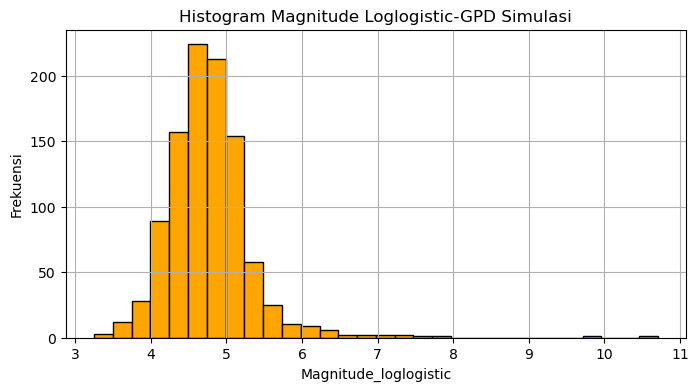

In [14]:
# 1. Generate uniform random numbers
u_rand = np.random.uniform(0, 1, n)

# 2. Inverse transform sampling untuk Loglogistic-GPD
def loglogistic_gpd_ppf(p, theta, gamma, xi, sigma_gpd, u):
    # Hitung proporsi loglogistic
    F_u = (u / theta) ** gamma / (1 + (u / theta) ** gamma)
    x = np.zeros_like(p)
    # Bagian loglogistic
    mask_logl = p < F_u
    x[mask_logl] = theta * (p[mask_logl] / (1 - p[mask_logl])) ** (1 / gamma)
    # Bagian GPD
    mask_gpd = ~mask_logl
    p_gpd = (p[mask_gpd] - F_u) / (1 - F_u)
    if xi != 0:
        x[mask_gpd] = u + sigma_gpd / xi * (1 - (1 - p_gpd) ** xi)
    else:
        x[mask_gpd] = u - sigma_gpd * np.log(1 - p_gpd)
    return x

# 3. Generate magnitude
simulasi['Magnitude_loglogistic'] = loglogistic_gpd_ppf(
    u_rand, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u
)

# 4. Hitung Event Rate
cdf_plus = loglogistic_comp_cdf(simulasi['Magnitude_loglogistic'] + e, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u)
cdf_minus = loglogistic_comp_cdf(simulasi['Magnitude_loglogistic'] - e, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u)
simulasi['Event Rate_loglogistic'] = (cdf_plus - cdf_minus) / 124

# --- Visualisasi ---
# Scatter mapbox warna = Magnitude_loglogistic
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    color="Magnitude_loglogistic",
    color_continuous_scale="Turbo",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik & Magnitude Loglogistic-GPD (warna = magnitude)",
    mapbox_style="open-street-map"
)
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)"
    )
)
fig.show()

# Histogram magnitude
plt.figure(figsize=(8,4))
plt.hist(simulasi['Magnitude_loglogistic'], bins=30, color='orange', edgecolor='k')
plt.xlabel('Magnitude_loglogistic')
plt.ylabel('Frekuensi')
plt.title('Histogram Magnitude Loglogistic-GPD Simulasi')
plt.grid(True)
plt.show()

In [15]:
simulasi

,Longitude,Latitude,Jarak_epi,Jarak,Kedalaman (km),Magnitude_burr,Event Rate_burr,Magnitude_loglogistic,Event Rate_loglogistic
0,107.530473,-8.092725,140.290460,140.287625,43.737932,4.268478,8.913879e-08,4.964962,1.246886e-07
1,108.124431,-8.701225,95.232019,95.231133,29.690522,4.808789,1.371884e-07,4.552112,1.426024e-07
2,107.948411,-7.753357,190.042668,190.035623,59.248028,3.963191,2.213808e-08,4.513305,1.353655e-07
3,107.593879,-9.343327,9.675766,9.675765,3.016645,4.525165,1.564735e-07,4.730511,1.565669e-07
4,108.150944,-8.880874,77.039650,77.039181,24.018757,4.274694,9.108195e-08,4.071670,3.988707e-08
...,...,...,...,...,...,...,...,...,...
995,109.115350,-9.624019,29.846614,29.846587,9.305368,4.482377,1.496608e-07,4.215245,6.582822e-08
996,108.971932,-8.811967,111.304713,111.303298,34.701393,5.500592,3.281853e-08,4.546866,1.416931e-07
997,109.264175,-9.636333,33.423919,33.423881,10.420673,5.152044,6.938819e-08,4.241487,7.150419e-08
998,108.648319,-8.899073,91.438931,91.438146,28.507970,3.980778,2.431111e-08,4.730255,1.565732e-07


## Lognormal-GPD

In [16]:
def log_likelihood_lognormal_gpd(params, data, u):
    mu, sigma_logn, xi, sigma_gpd = params
    if sigma_logn <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Lognormal part
    z = (np.log(below_u) - mu) / sigma_logn
    ll_logn = np.sum(-np.log(below_u * sigma_logn * np.sqrt(2 * np.pi)) - 0.5 * z**2)
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - norm.cdf((np.log(u) - mu) / sigma_logn)) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - norm.cdf((np.log(u) - mu) / sigma_logn)) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_logn + ll_gpd)  # negative for minimization

def estimate_lognormal_gpd(data, u):
    mu0 = np.mean(np.log(data[data < u]))
    sigma_logn0 = np.std(np.log(data[data < u]))
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (None, None),      # mu
        (1e-6, None),      # sigma_logn
        (-1, 1),           # xi
        (1e-6, None)       # sigma_gpd
    ]
    
    result = minimize(
        log_likelihood_lognormal_gpd,
        x0=[mu0, sigma_logn0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    mu, sigma_logn, xi, sigma_gpd = result.x
    print("Estimasi Parameter Lognormal-GPD")
    print("Parameter Lognormal:")
    print(f"\\mu (lokasi) = {mu:.4f}")
    print(f"\\sigma (skala) = {sigma_logn:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return mu, sigma_logn, xi, sigma_gpd

def logn_comp_cdf(x, mu, sigma_logn, xi, sigma_gpd, u):
    # CDF komposit lognormal-GPD
    cdf_logn = norm.cdf((np.log(np.minimum(x, u)) - mu) / sigma_logn)
    if np.isscalar(x):
        if x < u:
            return cdf_logn
        else:
            if xi != 0:
                cdf_gpd = 1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf = np.where(
            x < u,
            cdf_logn,
            np.where(
                xi != 0,
                1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

In [17]:
mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd = estimate_lognormal_gpd(data['mag'].values, u)

Estimasi Parameter Lognormal-GPD
Parameter Lognormal:
\mu (lokasi) = 1.5566
\sigma (skala) = 0.0980
Parameter GPD:
u (threshold) = 5.5000
\xi (bentuk) = -0.1028
\sigma (skala) = 0.4300


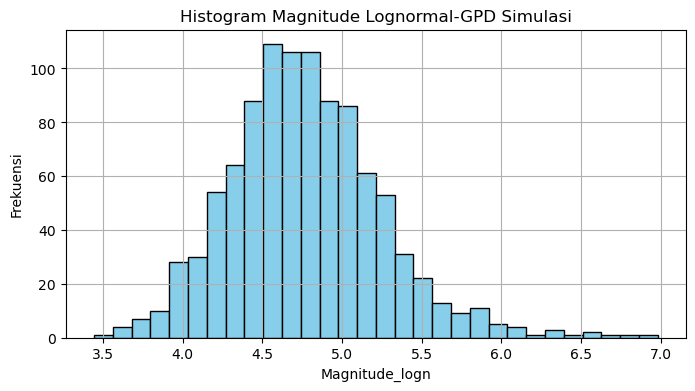

In [18]:
# 1. Generate uniform random numbers
u_rand = np.random.uniform(0, 1, n)

# 2. Inverse transform sampling untuk lognormal-GPD
def logn_gpd_ppf(p, mu, sigma_logn, xi, sigma_gpd, u):
    # Hitung proporsi lognormal
    p_logn = norm.cdf((np.log(u) - mu) / sigma_logn)
    x = np.zeros_like(p)
    # Bagian lognormal
    mask_logn = p < p_logn
    x[mask_logn] = np.exp(norm.ppf(p[mask_logn], loc=mu, scale=sigma_logn))
    # Bagian GPD
    mask_gpd = ~mask_logn
    p_gpd = (p[mask_gpd] - p_logn) / (1 - p_logn)
    if xi != 0:
        x[mask_gpd] = u + sigma_gpd / xi * (1 - (1 - p_gpd) ** xi)
    else:
        x[mask_gpd] = u - sigma_gpd * np.log(1 - p_gpd)
    return x

# 3. Generate magnitude
simulasi['Magnitude_logn'] = logn_gpd_ppf(
    u_rand, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u
)

# 4. Hitung Event Rate
cdf_plus = logn_comp_cdf(simulasi['Magnitude_logn'] + e, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)
cdf_minus = logn_comp_cdf(simulasi['Magnitude_logn'] - e, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)
simulasi['Event Rate_logn'] = (cdf_plus - cdf_minus) / 124

# --- Visualisasi ---
# Scatter mapbox warna = Magnitude_logn
fig = px.scatter_mapbox(
    simulasi,
    lat="Latitude",
    lon="Longitude",
    color="Magnitude_logn",
    color_continuous_scale="Turbo",
    zoom=6,
    height=600,
    width=800,
    title="Simulasi Lokasi Titik & Magnitude (warna = magnitude)",
    mapbox_style="open-street-map"
)
fig.add_scattermapbox(
    lat=list(batas['latitude']) + [batas['latitude'].iloc[0]],
    lon=list(batas['longitude']) + [batas['longitude'].iloc[0]],
    mode='lines',
    line=dict(color='red', width=2),
    name='Batas Area'
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255,255,255,0.7)"
    )
)
fig.show()

# Histogram magnitude
plt.figure(figsize=(8,4))
plt.hist(simulasi['Magnitude_logn'], bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Magnitude_logn')
plt.ylabel('Frekuensi')
plt.title('Histogram Magnitude Lognormal-GPD Simulasi')
plt.grid(True)
plt.show()

In [19]:
simulasi

,Longitude,Latitude,Jarak_epi,Jarak,Kedalaman (km),Magnitude_burr,Event Rate_burr,Magnitude_loglogistic,Event Rate_loglogistic,Magnitude_logn,Event Rate_logn
0,107.530473,-8.092725,140.290460,140.287625,43.737932,4.268478,8.913879e-08,4.964962,1.246886e-07,5.128124,9.322166e-08
1,108.124431,-8.701225,95.232019,95.231133,29.690522,4.808789,1.371884e-07,4.552112,1.426024e-07,4.004199,3.683600e-08
2,107.948411,-7.753357,190.042668,190.035623,59.248028,3.963191,2.213808e-08,4.513305,1.353655e-07,4.739501,1.386016e-07
3,107.593879,-9.343327,9.675766,9.675765,3.016645,4.525165,1.564735e-07,4.730511,1.565669e-07,5.257199,7.192145e-08
4,108.150944,-8.880874,77.039650,77.039181,24.018757,4.274694,9.108195e-08,4.071670,3.988707e-08,4.935500,1.225496e-07
...,...,...,...,...,...,...,...,...,...,...,...
995,109.115350,-9.624019,29.846614,29.846587,9.305368,4.482377,1.496608e-07,4.215245,6.582822e-08,4.468391,1.221581e-07
996,108.971932,-8.811967,111.304713,111.303298,34.701393,5.500592,3.281853e-08,4.546866,1.416931e-07,4.959352,1.194000e-07
997,109.264175,-9.636333,33.423919,33.423881,10.420673,5.152044,6.938819e-08,4.241487,7.150419e-08,4.933580,1.227945e-07
998,108.648319,-8.899073,91.438931,91.438146,28.507970,3.980778,2.431111e-08,4.730255,1.565732e-07,4.848925,1.320687e-07


# B-value dan Grafik

In [20]:
# --- Fungsi untuk GR fit dan summary ---
def gr_fit(mags):
    bin_width = 0.1
    bins = np.arange(mags.min(), mags.max() + bin_width, bin_width)
    hist, edges = np.histogram(mags, bins=bins)
    cum_hist = np.cumsum(hist[::-1])[::-1]
    log_cum_hist = np.log10(cum_hist[cum_hist > 0])
    mags_fit = edges[:-1][cum_hist > 0]
    slope, intercept, r_value, _, _ = linregress(mags_fit, log_cum_hist)
    return slope, intercept, r_value, mags_fit, log_cum_hist, bins

def get_Mc(mags):
    bin_width = 0.1
    bins = np.arange(mags.min(), mags.max() + bin_width, bin_width)
    hist, bin_edges = np.histogram(mags, bins=bins)
    Mc_index = np.argmax(hist)
    Mc = bin_edges[Mc_index]
    return Mc

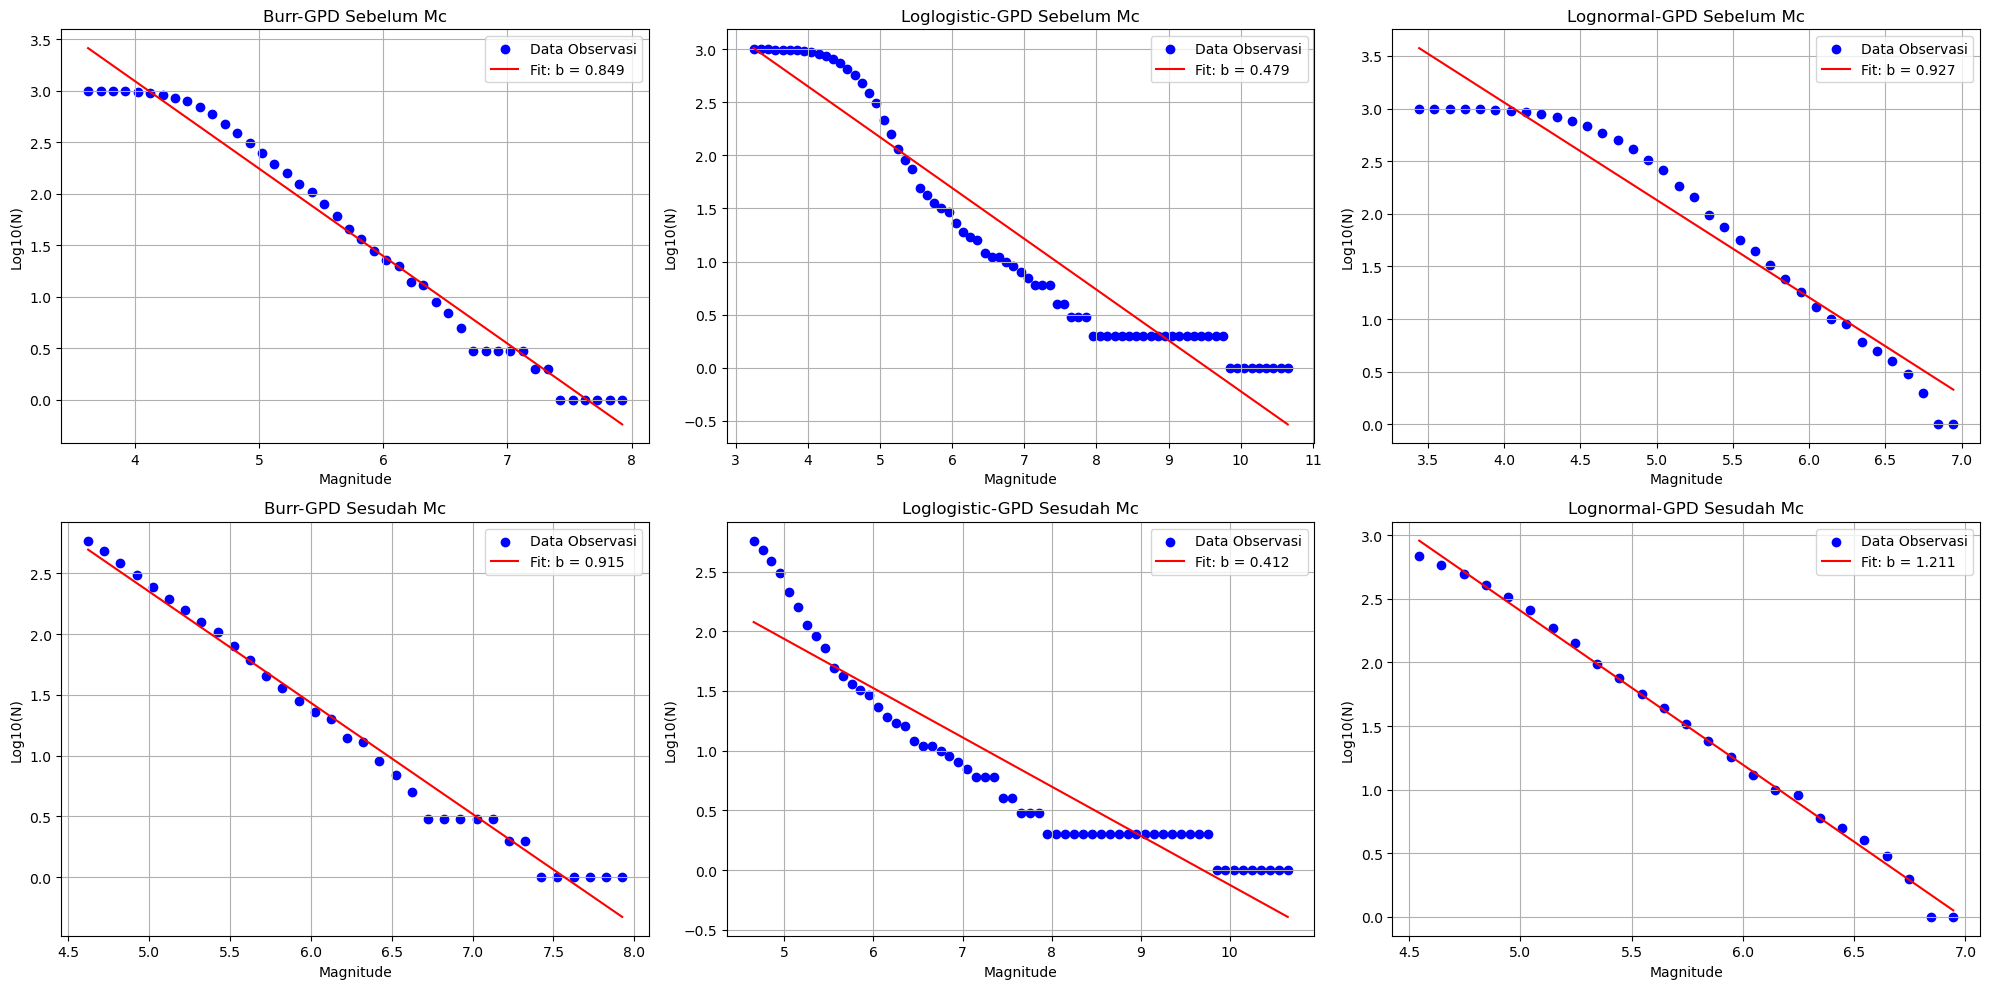

             Model        Mc   a-value   b-value       R^2
0         Burr-GPD  4.624578  6.487042  0.848549  0.979479
1  Loglogistic-GPD  4.651033  4.570334  0.479422  0.920376
2    Lognormal-GPD  4.544366  6.765805  0.926736  0.938449


In [21]:
# --- Proses untuk Burr-GPD, Loglogistic-GPD, dan Lognormal-GPD ---
results = []
fig, axs = plt.subplots(2, 3, figsize=(20, 10))  # 3 kolom untuk 3 model

model_info = [
    ('Burr-GPD', 'Magnitude_burr'),
    ('Loglogistic-GPD', 'Magnitude_loglogistic'),
    ('Lognormal-GPD', 'Magnitude_logn')
]

for i, (model, col) in enumerate(model_info):
    mags = simulasi[col].values

    # Sebelum Mc
    slope1, intercept1, r1, mags_fit1, log_cum_hist1, bins1 = gr_fit(mags)
    Mc = get_Mc(mags)
    # Sesudah Mc
    mags_after_Mc = mags[mags >= Mc]
    slope2, intercept2, r2, mags_fit2, log_cum_hist2, bins2 = gr_fit(mags_after_Mc)

    # Simpan ke tabel (hanya nilai sebelum Mc)
    results.append({
        'Model': model,
        'Mc': Mc,
        'a-value': intercept1,
        'b-value': -slope1,
        'R^2': r1**2
    })

    # Plot sebelum Mc
    ax = axs[0, i]
    ax.scatter(mags_fit1, log_cum_hist1, label='Data Observasi', color='blue')
    ax.plot(mags_fit1, slope1 * mags_fit1 + intercept1, label=f'Fit: b = {-slope1:.3f}', color='red')
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Log10(N)')
    ax.set_title(f'{model} Sebelum Mc')
    ax.legend()
    ax.grid(True)

    # Plot sesudah Mc
    ax = axs[1, i]
    ax.scatter(mags_fit2, log_cum_hist2, label='Data Observasi', color='blue')
    ax.plot(mags_fit2, slope2 * mags_fit2 + intercept2, label=f'Fit: b = {-slope2:.3f}', color='red')
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Log10(N)')
    ax.set_title(f'{model} Sesudah Mc')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- Tabel hasil ---
results_df = pd.DataFrame(results)
print(results_df)

# Running More Than 1 Times

In [22]:
# --- Sintaks untuk menjalankan Cell 4-27 sebanyak m kali dan merekap b-value setiap simulasi ---
bvalue_results = []

for sim in range(1, m+1):
    # --- Generate lokasi, kedalaman, magnitude, dst ---
    # Lokasi
    simulasi = monte_carlo_polygon(boundaries, n, polygon_path)
    simulasi = pd.DataFrame(simulasi, columns=['Longitude', 'Latitude'])

    # Kedalaman
    simulasi[['x', 'y', 'z']] = simulasi.apply(lambda row: pd.Series(longlat_to_xyz(row['Longitude'], row['Latitude'])), axis=1)
    bound = pd.DataFrame(batas.iloc[[0, 3]][['longitude', 'latitude']].values, columns=['longitude', 'latitude'])
    bound[['x', 'y', 'z']] = bound.apply(lambda row: pd.Series(longlat_to_xyz(row['longitude'], row['latitude'])), axis=1)
    a, b = bound.iloc[0][['x', 'y', 'z']].values, bound.iloc[1][['x', 'y', 'z']].values
    q_points = simulasi.apply(lambda row: project_point_to_line(row[['x', 'y', 'z']].values, a, b), axis=1)
    q_longlats = pd.DataFrame([xyz_to_longlat(*q) for q in q_points], columns=['q_lon', 'q_lat'])
    simulasi[['q_lon', 'q_lat']] = q_longlats
    simulasi['Jarak_epi'] = simulasi.apply(lambda row: haversine(row['Latitude'], row['Longitude'], row['q_lat'], row['q_lon']), axis=1)
    simulasi['Jarak'] = 2 * R * np.sin(simulasi['Jarak_epi'] / (2 * R))
    simulasi['Kedalaman (km)'] = simulasi['Jarak'] * np.tan(theta)
    simulasi.drop(columns=['x', 'y', 'z', 'q_lon', 'q_lat'], inplace=True)

    # Magnitude Burr-GPD
    u_rand_burr = np.random.uniform(0, 1, n)
    simulasi['Magnitude_burr'] = burr_gpd_ppf(u_rand_burr, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u)

    # Magnitude Loglogistic-GPD
    u_rand_loglog = np.random.uniform(0, 1, n)
    simulasi['Magnitude_loglogistic'] = loglogistic_gpd_ppf(u_rand_loglog, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u)

    # Magnitude Lognormal-GPD
    u_rand_logn = np.random.uniform(0, 1, n)
    simulasi['Magnitude_logn'] = logn_gpd_ppf(u_rand_logn, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)

    # --- Hitung b-value sebelum Mc untuk ketiga model ---
    def get_bvalue(mags):
        bin_width = 0.1
        bins = np.arange(mags.min(), mags.max() + bin_width, bin_width)
        hist, edges = np.histogram(mags, bins=bins)
        cum_hist = np.cumsum(hist[::-1])[::-1]
        log_cum_hist = np.log10(cum_hist[cum_hist > 0])
        mags_fit = edges[:-1][cum_hist > 0]
        slope, _, _, _, _ = linregress(mags_fit, log_cum_hist)
        return -slope

    bval_burr = get_bvalue(simulasi['Magnitude_burr'].values)
    bval_loglog = get_bvalue(simulasi['Magnitude_loglogistic'].values)
    bval_logn = get_bvalue(simulasi['Magnitude_logn'].values)

    bvalue_results.append({
        "Simulasi ke-": sim,
        "Burr-GPD": bval_burr,
        "Loglogistic-GPD": bval_loglog,
        "Lognormal-GPD": bval_logn
    })

# Output tabel b-value tiap simulasi
print(f"Simulasi n = {n}")
bvalue_df = pd.DataFrame(bvalue_results)
print(bvalue_df)

Simulasi n = 1000
   Simulasi ke-  Burr-GPD  Loglogistic-GPD  Lognormal-GPD
0             1  0.740119         0.150861       0.611418
1             2  0.702096         0.578537       0.813486
2             3  0.723575         0.316693       0.535775
3             4  0.866993         0.703209       0.856065
4             5  0.671939         0.508719       0.864704
5             6  0.774244         0.266542       0.876286
6             7  0.703056         0.362512       0.867779
7             8  0.464931         0.574037       0.857796
8             9  0.795168         0.412313       0.762657
9            10  0.654277         0.748272       0.772740
